### Author: DOTA  
##### Datetime: 2021-5-2 05:20:1314
#### 微信公众号：**炼丹笔记**
###### 开源详解链接：
###### https://mp.weixin.qq.com/s/BVVYuQuvVgNZ9VDe7bLBAw  
###### https://zhuanlan.zhihu.com/p/368650520
###### KDD2021：
###### https://compete.hexagon-ml.com/practice/competition/39/

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from matplotlib import pyplot as plt

In [5]:
filename = 'data_phase2/004_UCR_Anomaly_2500.txt'

In [6]:
data = pd.read_csv(filename,names=['value'])
point = 2500
n_steps = 100
dota = 1.15

In [7]:
train = data.iloc[:point].reset_index(drop=True)
test  = data.iloc[point:].reset_index(drop=True)

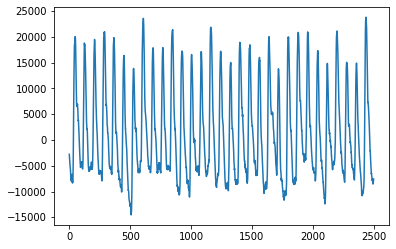

In [8]:
fig, ax = plt.subplots()
train.plot(legend=False, ax=ax)
plt.show()

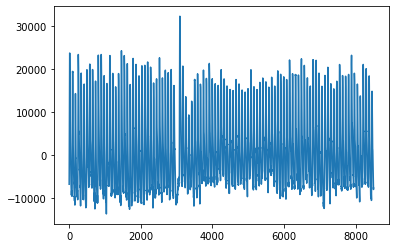

In [9]:
fig, ax = plt.subplots()
test.plot(legend=False, ax=ax)
plt.show()

In [11]:
# for normalizing test data.
training_mean = train.mean()
training_std = train.std()
training_value = (train - training_mean) / training_std
print("Number of training samples:", len(training_value))

Number of training samples: 2500


In [12]:
def create_sequences(values, steps=n_steps):
    output = []
    for i in range(len(values) - steps):
        output.append(values[i : (i + steps)])
    return np.stack(output)

x_train = create_sequences(training_value.values)

In [13]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=16, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=8, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=8, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=16, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 16)            80        
_________________________________________________________________
dropout (Dropout)            (None, 50, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 8)             520       
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 50, 8)             264       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 8)             0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 100, 16)           528       
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 100, 1)            1

In [17]:
dota_model = model.fit(
                        x_train,
                        x_train,
                        epochs=2009,
                        batch_size=64,
                        validation_split=0.2,
                        callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")],
                    )

Epoch 1/2009
4/4 [==============================] - 0s 48ms/step - loss: 0.2808 - val_loss: 0.2082
Epoch 2/2009
4/4 [==============================] - 0s 39ms/step - loss: 0.2612 - val_loss: 0.1927
Epoch 3/2009
4/4 [==============================] - 0s 30ms/step - loss: 0.2452 - val_loss: 0.1780
Epoch 4/2009
4/4 [==============================] - 0s 33ms/step - loss: 0.2297 - val_loss: 0.1641
Epoch 5/2009
4/4 [==============================] - 0s 33ms/step - loss: 0.2146 - val_loss: 0.1511
Epoch 6/2009
4/4 [==============================] - 0s 39ms/step - loss: 0.2023 - val_loss: 0.1389
Epoch 7/2009
4/4 [==============================] - 0s 38ms/step - loss: 0.1908 - val_loss: 0.1275
Epoch 8/2009
4/4 [==============================] - 0s 29ms/step - loss: 0.1809 - val_loss: 0.1171
Epoch 9/2009
4/4 [==============================] - 0s 31ms/step - loss: 0.1677 - val_loss: 0.1075
Epoch 10/2009
4/4 [==============================] - 0s 32ms/step - loss: 0.1599 - val_loss: 0.0987
Epoch 11/

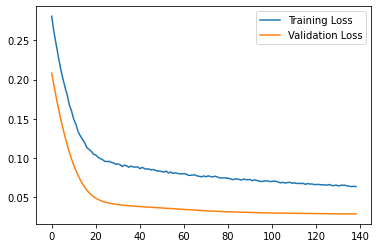

In [18]:
plt.plot(dota_model.history["loss"], label="Training Loss")
plt.plot(dota_model.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

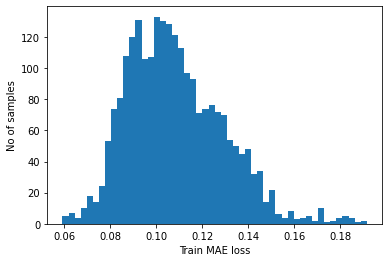

Reconstruction error threshold:  0.1914261159603399


In [20]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

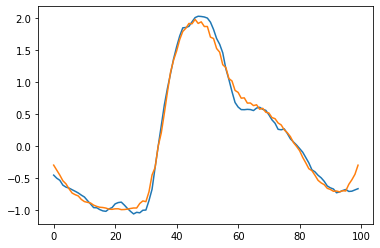

In [21]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

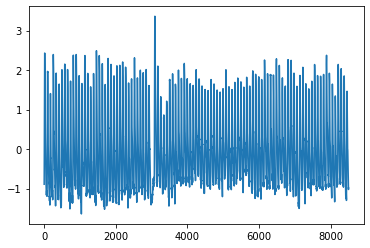

Test input shape:  (8400, 100, 1)


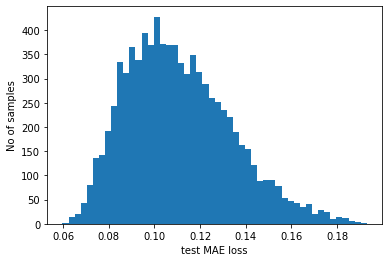

Number of anomaly samples:  0
Indices of anomaly samples:  (array([], dtype=int64),)


In [22]:
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values

df_test_value = (test - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

anomalies = test_mae_loss > threshold * dota
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

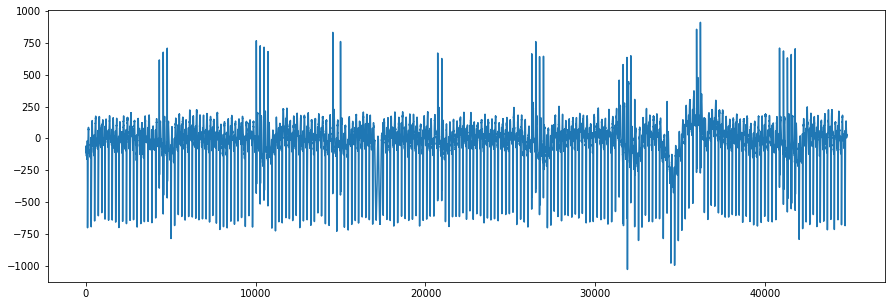